# Episodic Memory - Learning from Conversations

**Purpose:** Prove the agent remembers past conversations, generates reflections, and uses recency-weighted recall.

This notebook demonstrates episodic memory - the ability to store past conversation experiences with LLM-generated reflections and retrieve them using recency-weighted similarity search.

| Feature | Detail |
|---------|--------|
| **Storage** | ChromaDB collection (separate from semantic) |
| **Reflection** | LLM generates summary, context tags, what worked/avoid for each conversation |
| **Retrieval** | Cosine similarity (70%) + recency decay (30%) |
| **Recency** | Exponential decay, half-life = 72 hours |
| **Retrieval Gating** | Queries classified as personal/factual/behavioral to route to relevant memory systems |

### Test Design

We compare two agents on the same recall questions:
- **Full Agent** - has episodic memory from past conversations
- **Baseline** - semantic-only RAG, no conversation memory

The full agent should recall user-specific details that exist ONLY in past conversations (not in the PDF).

In [1]:
import os, sys, json, shutil, time, textwrap, re
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML, Markdown

sys.path.insert(0, '..')
os.chdir('..')

from dotenv import load_dotenv
load_dotenv(dotenv_path='.env')
assert os.environ.get('ANTHROPIC_API_KEY'), 'ANTHROPIC_API_KEY not set - check .env file'

# Clean slate
if os.path.exists('chroma_db'):
    shutil.rmtree('chroma_db')
if os.path.exists('procedural_memory.txt'):
    os.remove('procedural_memory.txt')

os.makedirs('figures', exist_ok=True)


def show_chat(question, response, label='', agent_name='Agent'):
    badge = ''
    if label:
        if 'PASS' in label.upper(): badge_color = '#27ae60'
        elif 'FAIL' in label.upper(): badge_color = '#e74c3c'
        elif 'PARTIAL' in label.upper(): badge_color = '#f39c12'
        else: badge_color = '#7f8c8d'
        badge = f'<span style="background:{badge_color};color:white;padding:2px 8px;border-radius:4px;font-size:12px;font-weight:bold;">{label}</span> '
    resp_escaped = response.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;')
    resp_html = resp_escaped.replace('\n', '<br>')
    html = f"""
    <div style="margin:10px 0;">
        {badge}
        <div style="border-left:3px solid #3498db;padding:8px 12px;margin:6px 0;background:#f0f7ff;border-radius:0 4px 4px 0;">
            <strong style="color:#2c3e50;">User:</strong> {question}
        </div>
        <div style="border-left:3px solid #27ae60;padding:8px 12px;margin:6px 0;background:#f0fff0;border-radius:0 4px 4px 0;">
            <strong style="color:#2c3e50;">{agent_name}:</strong><br>{resp_html}
        </div>
    </div>
    """
    display(HTML(html))


def show_comparison(question, baseline_resp, full_resp, baseline_pass, full_pass, label=''):
    b_color = '#27ae60' if baseline_pass else '#e74c3c'
    f_color = '#27ae60' if full_pass else '#e74c3c'
    b_tag = 'PASS' if baseline_pass else 'FAIL'
    f_tag = 'PASS' if full_pass else 'FAIL'
    def esc(t):
        return t.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;').replace('\n', '<br>')
    label_html = f'<div style="color:#7f8c8d;font-size:12px;margin-bottom:4px;">{label}</div>' if label else ''
    html = f"""
    <div style="margin:12px 0;">
        {label_html}
        <div style="border-left:3px solid #3498db;padding:8px 12px;margin:6px 0;background:#f0f7ff;">
            <strong>Q:</strong> {question}
        </div>
        <div style="display:flex;gap:12px;">
            <div style="flex:1;border-left:3px solid {b_color};padding:8px 12px;background:#fafafa;">
                <span style="background:{b_color};color:white;padding:1px 6px;border-radius:3px;font-size:11px;">{b_tag}</span>
                <strong> Baseline:</strong><br>{esc(baseline_resp)}
            </div>
            <div style="flex:1;border-left:3px solid {f_color};padding:8px 12px;background:#fafafa;">
                <span style="background:{f_color};color:white;padding:1px 6px;border-radius:3px;font-size:11px;">{f_tag}</span>
                <strong> Full Agent:</strong><br>{esc(full_resp)}
            </div>
        </div>
    </div>
    """
    display(HTML(html))


print('Environment ready.')

Environment ready.


In [2]:
from agent import CognitiveAgent

full_agent = CognitiveAgent(mode='full')
baseline_agent = CognitiveAgent(mode='semantic_only')

print(f'Full agent: {full_agent.semantic.collection.count()} semantic chunks')
print(f'Baseline:   {baseline_agent.semantic.collection.count()} semantic chunks')
print(f'Episodic memories: {full_agent.episodic.collection.count()}')

Loading semantic memory (mode=full)...


  Ingested: zeltron_manual.pdf -> 16 chunks


Loading semantic memory (mode=semantic_only)...
  Already ingested: zeltron_manual.pdf (16 chunks)
Full agent: 16 semantic chunks
Baseline:   16 semantic chunks
Episodic memories: 0


## Phase 1: Build Episodic Memories

We run 3 multi-turn conversations with the full agent. Each conversation plants **user-specific details** that exist ONLY in conversation history - not in the Zeltron PDF.

| Conv | Topic | Planted Details |
|------|-------|-----------------|
| 1 | Project evaluation | Budget = $50k, Uppsala data center, needs low-latency |
| 2 | User preferences | Prefers detailed technical answers, works in fintech |
| 3 | Zeltron question + feedback | Helpful response, needs NATO compliance |

In [3]:
display(Markdown('### Building Episodic Memories'))

conversations = [
    {
        'topic': 'Project Evaluation',
        'messages': [
            'I am evaluating acoustic computing for our Uppsala data center. We need low-latency processing for financial transactions.',
            'Our budget is around $50,000 for the initial proof-of-concept. Is the QA-7 within that range?',
            'Latency is critical for us - we need sub-millisecond response times for our trading engine.',
        ]
    },
    {
        'topic': 'User Preferences',
        'messages': [
            'Tell me about the QA-7 processor architecture in detail.',
            'I prefer very detailed technical explanations - I work in fintech and need to understand the hardware deeply.',
            'Can you always include specific numbers and benchmarks when answering my questions?',
        ]
    },
    {
        'topic': 'Follow-up + Compliance',
        'messages': [
            'What security certifications does Zeltron have?',
            'That was helpful, thanks. Remember that I need NATO compliance for our deployment.',
            'Any known vulnerabilities in the acoustic computing approach?',
        ]
    },
]

episode_counts = []
for i, conv in enumerate(conversations):
    display(Markdown(f'**Conversation {i+1}: {conv["topic"]}**'))
    for msg in conv['messages']:
        response = full_agent.chat(msg)
        show_chat(msg, response, agent_name='Full Agent')
    full_agent.new_conversation()
    episode_counts.append(full_agent.episodic.collection.count())
    print(f'  Episodes stored: {episode_counts[-1]}')

display(Markdown(f'\n**{episode_counts[-1]} episodic memories built from {len(conversations)} conversations.**'))

### Building Episodic Memories

**Conversation 1: Project Evaluation**

  Saving episodic memory...


  Updating procedural memory...


  Episodes stored: 1


**Conversation 2: User Preferences**

  Saving episodic memory...


  Updating procedural memory...


  Episodes stored: 2


**Conversation 3: Follow-up + Compliance**

  Saving episodic memory...


  Updating procedural memory...


  Episodes stored: 3



**3 episodic memories built from 3 conversations.**

In [4]:
display(Markdown('## Stored Episodic Memories\n'))

all_episodes = full_agent.episodic.get_all()
for i, ep in enumerate(all_episodes):
    meta = ep['metadata']
    display(HTML(f"""
    <div style="border:1px solid #ddd;border-radius:6px;padding:12px;margin:8px 0;background:#fafafa;">
        <strong style="color:#8e44ad;">Episode {i+1}</strong> <span style="color:#999;font-size:12px;">({ep['id']})</span>
        <div style="margin-top:6px;">
            <strong>Summary:</strong> {meta.get('summary', 'N/A')}<br>
            <strong>Tags:</strong> {meta.get('context_tags', 'N/A')}<br>
            <strong>What worked:</strong> {meta.get('what_worked', 'N/A')}<br>
            <strong>What to avoid:</strong> {meta.get('what_to_avoid', 'N/A')}
        </div>
    </div>
    """))

## Stored Episodic Memories


In [5]:
display(Markdown('## Retrieval Gating Demo\n'))
display(Markdown('The agent classifies queries to route them to the right memory systems, saving unnecessary calls.\n'))

gating_tests = [
    ('Do you remember my budget?', 'Personal - should route to episodic only'),
    ('What is the Zeltron stock ticker?', 'Factual - should route to semantic only'),
    ('How should I deploy the QA-7 at my facility?', 'Behavioral - should route to all systems'),
    ('Tell me about competitors.', 'General factual - semantic only'),
    ('What did we discuss about my data center?', 'Personal recall - episodic only'),
]

for query, desc in gating_tests:
    routing = full_agent._classify_query(query)
    active = [k for k, v in routing.items() if v]
    display(HTML(f"""
    <div style="margin:6px 0;padding:8px 12px;background:#f5f5f5;border-radius:4px;">
        <strong>Q:</strong> \"{query}\"<br>
        <span style="color:#666;font-size:12px;">{desc}</span><br>
        <strong>Routing:</strong> {routing}<br>
        <strong>Active systems:</strong> {', '.join(active)}
    </div>
    """))

## Retrieval Gating Demo


The agent classifies queries to route them to the right memory systems, saving unnecessary calls.


In [6]:
display(Markdown('## Episodic Recall Test\n'))
display(Markdown('Both agents answer the same questions about past conversations. The baseline has no episodic memory.\n'))

recall_tests = [
    {'question': 'Do you remember my budget for the proof-of-concept?', 'check': ['50,000', '$50k', '50000', '50k', '50K', 'fifty thousand', '50 thousand'], 'check_any': True, 'topic': 'Budget recall'},
    {'question': 'What did we discuss about my data center location?', 'check': ['Uppsala'], 'topic': 'Location recall'},
    {'question': 'What kind of answers do I prefer?', 'check': ['detail', 'technical'], 'check_any': True, 'topic': 'Preference recall'},
    {'question': 'What compliance requirement did I mention?', 'check': ['NATO'], 'topic': 'Compliance recall'},
]

recall_baseline = []
recall_full = []

for test in recall_tests:
    baseline_agent.working.reset()
    b_resp = baseline_agent.chat(test['question'])

    full_agent.working.reset()
    f_resp = full_agent.chat(test['question'])

    if test.get('check_any'):
        b_passed = any(kw.lower() in b_resp.lower() for kw in test['check'])
        f_passed = any(kw.lower() in f_resp.lower() for kw in test['check'])
    else:
        b_passed = all(kw.lower() in b_resp.lower() for kw in test['check'])
        f_passed = all(kw.lower() in f_resp.lower() for kw in test['check'])

    recall_baseline.append({'passed': b_passed})
    recall_full.append({'passed': f_passed})

    show_comparison(test['question'], b_resp, f_resp, b_passed, f_passed, label=test['topic'])

b_score = sum(r['passed'] for r in recall_baseline)
f_score = sum(r['passed'] for r in recall_full)
print(f'\nRecall: Baseline {b_score}/{len(recall_tests)} | Full Agent {f_score}/{len(recall_tests)}')

## Episodic Recall Test


Both agents answer the same questions about past conversations. The baseline has no episodic memory.



Recall: Baseline 1/4 | Full Agent 3/4


In [7]:
display(Markdown('## Recency Weighting Demo\n'))
display(Markdown('Adding a 4th conversation and showing how recall ranking changes - newer memories are weighted higher.\n'))

# Show recall scores BEFORE new conversation
pre_results = full_agent.episodic.recall('Uppsala data center deployment')
display(Markdown('### Before New Conversation'))
if pre_results:
    for i, ep in enumerate(pre_results):
        meta = ep['metadata']
        display(HTML(f'<div style="padding:4px 8px;margin:2px 0;"><strong>#{i+1}</strong> (score={ep["score"]:.3f}) {meta.get("summary", "N/A")}</div>'))

# New conversation about the same topic (should rank higher due to recency)
display(Markdown('\n### Adding Conversation 4 (overlapping topic: Uppsala deployment)'))
full_agent.working.reset()
for msg in [
    'Let me revisit the Uppsala deployment - we have updated our requirements.',
    'We now need the system operational by Q3 2026. Is that feasible with Zeltron lead times?',
]:
    response = full_agent.chat(msg)
    show_chat(msg, response, agent_name='Full Agent')
full_agent.new_conversation()

# Show recall scores AFTER new conversation
time.sleep(0.1)  # ensure different timestamp
post_results = full_agent.episodic.recall('Uppsala data center deployment')
display(Markdown('\n### After New Conversation'))
if post_results:
    for i, ep in enumerate(post_results):
        meta = ep['metadata']
        display(HTML(f'<div style="padding:4px 8px;margin:2px 0;"><strong>#{i+1}</strong> (score={ep["score"]:.3f}) {meta.get("summary", "N/A")}</div>'))

display(Markdown('\n*The newest conversation about Uppsala should now rank higher due to recency weighting.*'))

## Recency Weighting Demo


Adding a 4th conversation and showing how recall ranking changes - newer memories are weighted higher.


### Before New Conversation


### Adding Conversation 4 (overlapping topic: Uppsala deployment)

  Saving episodic memory...


  Updating procedural memory...



### After New Conversation


*The newest conversation about Uppsala should now rank higher due to recency weighting.*

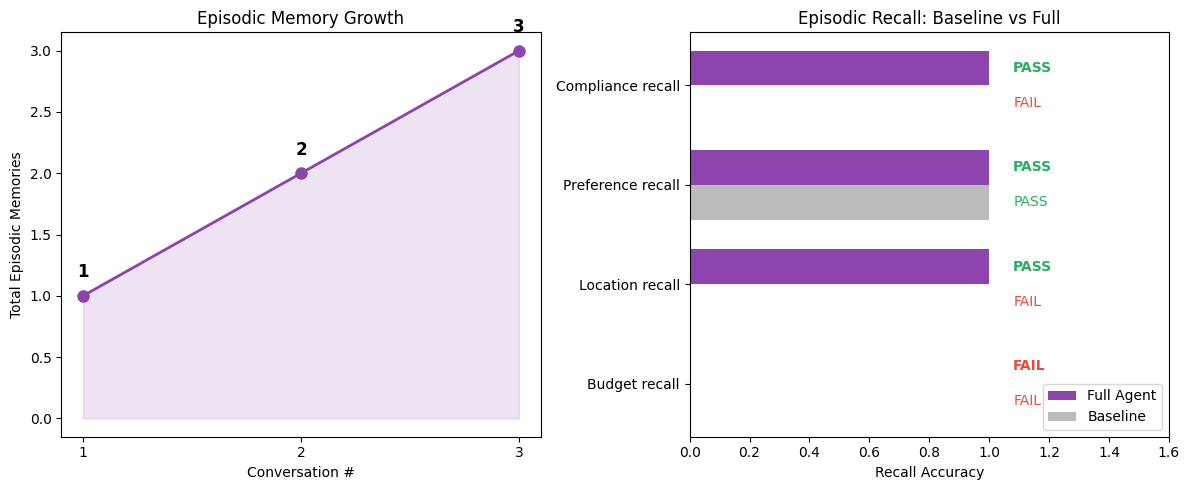

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Episode growth
x = list(range(1, len(episode_counts) + 1))
axes[0].plot(x, episode_counts, 'o-', color='#8e44ad', linewidth=2, markersize=8)
axes[0].fill_between(x, episode_counts, alpha=0.15, color='#8e44ad')
axes[0].set_xlabel('Conversation #')
axes[0].set_ylabel('Total Episodic Memories')
axes[0].set_title('Episodic Memory Growth')
axes[0].set_xticks(x)
for i, c in enumerate(episode_counts):
    axes[0].text(x[i], c + 0.15, str(c), ha='center', fontweight='bold', fontsize=12)

# Right: Recall comparison
categories = [t['topic'] for t in recall_tests]
b_scores = [int(r['passed']) for r in recall_baseline]
f_scores = [int(r['passed']) for r in recall_full]
y = np.arange(len(categories))
h = 0.35

axes[1].barh(y + h/2, f_scores, h, color='#8e44ad', label='Full Agent')
axes[1].barh(y - h/2, b_scores, h, color='#bbb', label='Baseline')

# Aligned labels - all at same x position so PASS/FAIL line up vertically
label_x = 1.08
for i in range(len(categories)):
    axes[1].text(label_x, y[i] + h/2, 'PASS' if f_scores[i] else 'FAIL',
                 va='center', fontweight='bold', fontsize=10,
                 color='#27ae60' if f_scores[i] else '#e74c3c')
    axes[1].text(label_x, y[i] - h/2, 'PASS' if b_scores[i] else 'FAIL',
                 va='center', fontsize=10,
                 color='#27ae60' if b_scores[i] else '#e74c3c')

axes[1].set_yticks(y)
axes[1].set_yticklabels(categories)
axes[1].set_xlabel('Recall Accuracy')
axes[1].set_title('Episodic Recall: Baseline vs Full')
axes[1].set_xlim(0, 1.6)
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.savefig('figures/episodic_test.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## Summary

**What this proves about episodic memory:**

1. **Conversation storage works** - Each conversation is reflected on and stored with structured metadata (summary, tags, what worked/avoid)
2. **Recall works** - The full agent retrieves relevant past experiences when asked about user-specific details
3. **Baseline cannot recall** - Without episodic memory, the baseline agent has zero knowledge of past conversations
4. **Retrieval gating** - Queries are classified to route personal queries to episodic memory and factual queries to semantic memory, avoiding unnecessary retrieval
5. **Recency weighting** - Newer memories about the same topic rank higher, reflecting the natural priority of recent experience

The episodic memory system gives the agent a persistent sense of "who the user is" and "what we have discussed" - something impossible with vanilla RAG alone.